## Simple example of a single neuron simulation

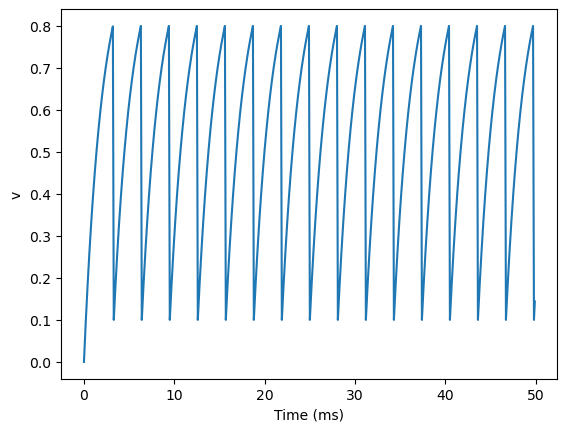

In [2]:
from brian2 import *

start_scope()

tau = 2*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0.1', method='exact')

M = StateMonitor(G, 'v', record=0)

run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

# Generating Step Current and a Gaussian noise for injecting in the Neuron

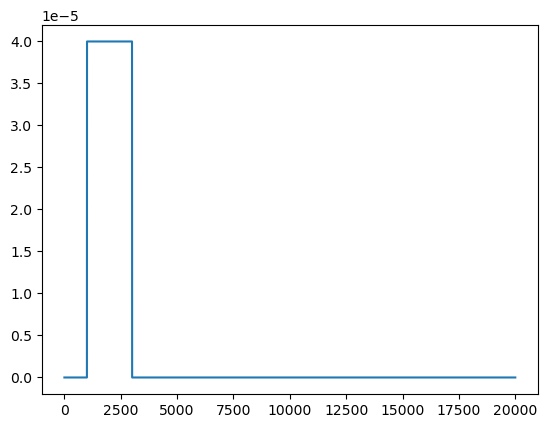

In [3]:
def get_step_current(t_start, t_end,total_length, unit_time, amplitude, append_zero=True):


    assert isinstance(t_start, int), "t_start_ms must be of type int"
    assert isinstance(t_end, int), "t_end must be of type int"
    assert units.fundamentalunits.have_same_dimensions(amplitude, amp), \
        "amplitude must have the dimension of current e.g. brian2.uamp"
    tmp_size = total_length/unit_time  # +1 for t=0
    if append_zero:
        tmp_size += 1
    tmp = np.zeros((int(tmp_size), 1)) * amp
    tmp[int(t_start/unit_time): int(t_end/unit_time) + 1, 0] = amplitude
    curr = TimedArray(tmp, dt=1. * unit_time*ms)
    return curr

plt.plot(get_step_current(50, 150, 1000, 1./20, 40*uA))
plt.show()

### Functions for generating noise

In [4]:
import scipy

def get_noisy_current( t_end, unit_time, mu, sig,unit, myseed=10):

    """Creates a noise injection.
    Args:
        t_end (int): end of the step
        unit_time (Brian2 unit): unit of t_start and t_end. e.g. 0.1*brian2.ms
        mu (Quantity): mean of gaussian noise. e.g. 3.5*brian2.uamp
        sig (Quantity): standard deviation of gaussian noise. e.g. 3.5*brian2.uamp
        unit (Quantity): unit of the current usially uA

    Returns:
        TimedArray: Brian2.TimedArray
    """


    # Retrieve simulation parameters
    dt = 1. * unit_time
    Lt =  t_end

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = np.zeros((Lt*20,1))
    I_gwn[:,0] = (mu+ sig * np.random.randn(Lt*20))

    tmp = I_gwn*unit
    curr = TimedArray(tmp, dt=1. * unit_time)
    return curr

def get_noisy_current_OU( t_end, unit_time, I_stim0,I_avg, unit, tau_n = 10, sig_noise = 10, myseed=10):

    """Creates a noise injection using Ornstein-Uhlenbeck (OU) process.
    Args:
        t_end (int): end of the step in ms
        unit_time (Brian2 unit): unit of t_start and t_end. e.g. 0.1*brian2.ms
        I_stim0 (int): inital value for the injected current
        unit (Quantity): unit of the current usially uA
        tau_n (Quantity): noise time constant
        sig_noise (Quantity): standard deviation of noise

    Returns:
        TimedArray: Brian2.TimedArray
    """


    # Retrieve simulation parameters
    dt = 1. * unit_time
    Lt =  t_end

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = np.zeros((Lt*20,1))


    I_stim = np.zeros((t_end*20))
    I_stim[0] = I_stim0

    for t_ in range(1,t_end*20):
        I_stim[t_]=I_avg+((I_avg-I_stim[t_-1])/tau_n)+sig_noise*np.random.normal(0,1)

    I_gwn[:,0] = I_stim

    tmp = I_gwn*unit
    curr = TimedArray(tmp, dt=1. * unit_time)
    return curr


# Morris Lecar Model simulation for three different types of inputs.
We first inject step current and then with a gaussian white noise
The Morris Lecar model is described below taken from: Biophysical Basis for Three Distinct Dynamical Mechanisms of Action Potential Initiation
Prescott SA, De Koninck Y, Sejnowski TJ (2008) Biophysical Basis for Three Distinct Dynamical Mechanisms of Action Potential Initiation. PLOS Computational Biology 4(10): e1000198. https://doi.org/10.1371/journal.pcbi.1000198

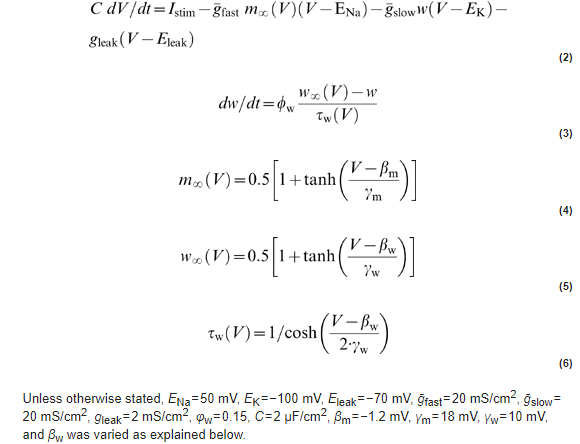

#Running Morris Lecar model with step current
The excitabilty types are changed by changing 𝜷w


type I:   𝛽w = 0mV

type II:  𝛽w = -13mV

type III: 𝛽w = -21mV





In [5]:
def run_ML_with_step(ex_type,input_amp,plot_=True ):
    '''
    Brian 2 simulation of Morris Lecar model with step current

    Args:
    ex_type: (str) 'I' for type I and so on
    input_amp: (int) amplitude of the step current in uA
    plot: (bool) plot the output or not
    '''
    start_scope()
    defaultclock.dt = 1/20*ms
    # ex_type = 'I'
    g_Leak = 2*mS

    g_slow = 20*mS
    E_Leak = -70*mV
    E_fast = 50*mV
    V_slow = -100*mV
    beta_m = -1.2*mV
    gamma_m = 18*mV  # Note that Figure caption says -15 which seems to be a typo
    g_fast = 20*mS #
    phi_w = 1.5/(10*ms) #
    if ex_type=='I':
        beta_w = -0*mV # change to change the neuron type
    elif ex_type=='II':
        beta_w = -13*mV # change to change the neuron type
    elif ex_type=='III':
        beta_w = -21*mV # change to change the neuron type
    else:
        raise Exception('Input should be either I, II, or III')
    gamma_w = 10*mV #
    C = 2*uF


    # V,N-reduced system (Eq. 9 in article), note that the variables M and N (and lambda_N, etc.)
    # have been renamed to m and n to better match the Hodgkin-Huxley convention, and because N has
    # a reserved meaning in Brian (number of neurons)
    eqs = '''
    I = input_current(t,i) : amp
    dV/dt = (-g_Leak*(V - E_Leak) - g_fast*m_inf*(V - E_fast) - g_slow*n*(V - V_slow) + I)/C : volt
    dn/dt = (phi_w/tau_w)*(n_inf - n) : 1
    m_inf = 0.5*(1 + tanh((V - beta_m)/gamma_m)) : 1
    n_inf = 0.5*(1 + tanh((V - beta_w)/gamma_w)) : 1
    tau_w = 1/cosh((V - beta_w)/(2*gamma_w)) : 1

    '''

    G = NeuronGroup(1, eqs, method='exponential_euler')
    input_current = get_step_current(200, 400, 1000, 1./20, input_amp*uA)

    M = StateMonitor(G, ['V','I'], record=0)

    G.V = E_Leak
    G.namespace["input_current"] = input_current

    run(1000*ms)
    spikes = scipy.signal.find_peaks(np.array(M.V[0]/mV),height=0.1)[0]
    firing_rate = len(spikes)*1000/200
    if plot_:
        plot(M.t/ms, M.V[0]/mV)
        plt.scatter(np.array(M.t/ms)[spikes], np.array(M.V[0]/mV)[spikes],c='r')
        title('type '+ex_type+' neuron beta_w='+str(beta_w/mV)+'mV')
        xlabel('Time (ms)')
        ylabel('v');
        plt.show()
    return firing_rate


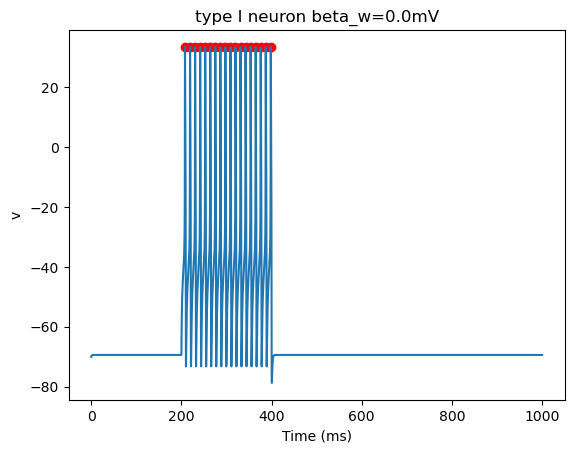

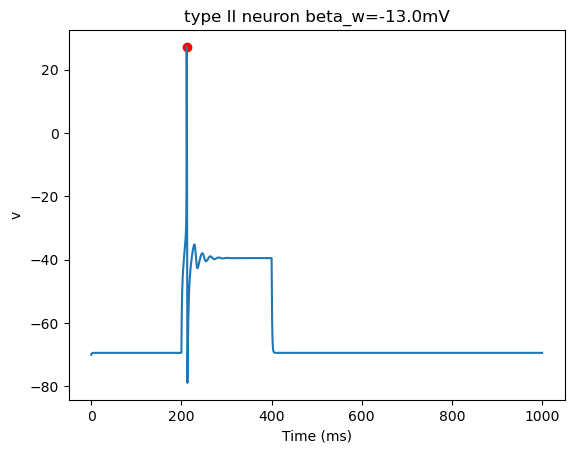

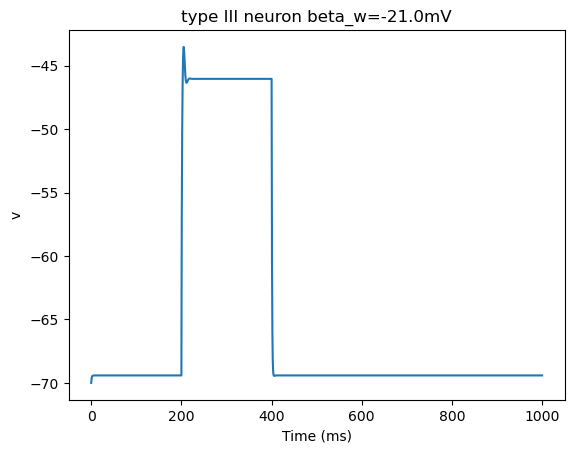

0.0

In [6]:
run_ML_with_step('I',42,plot_=True)
run_ML_with_step('II',42,plot_=True)
run_ML_with_step('III',42,plot_=True)

In [7]:
I_amps_type1 = np.arange(35,80)
fr_type1 = []
for I_amp_ in range(35,80):
    fr_type1.append(run_ML_with_step('I',I_amp_,plot_=False))

I_amps_type2 = np.arange(35,80)
fr_type2 = []
for I_amp_ in range(35,80):
    fr_type2.append(run_ML_with_step('II',I_amp_,plot_=False))

I_amps_type3 = np.arange(35,80)
fr_type3 = []
for I_amp_ in range(35,80):
    fr_type3.append(run_ML_with_step('III',I_amp_,plot_=False))


# Different excitability types shown with FI curves

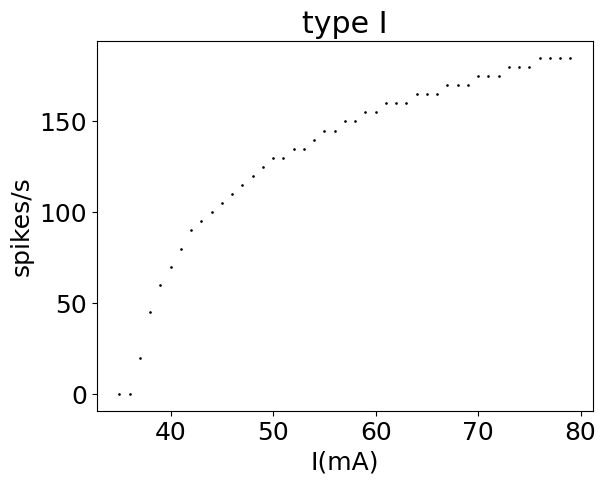

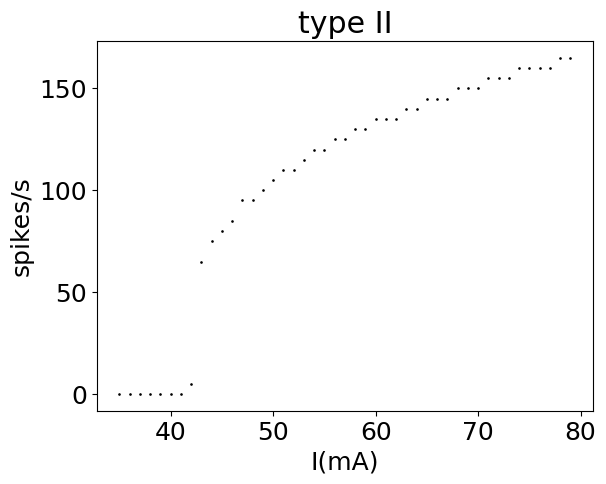

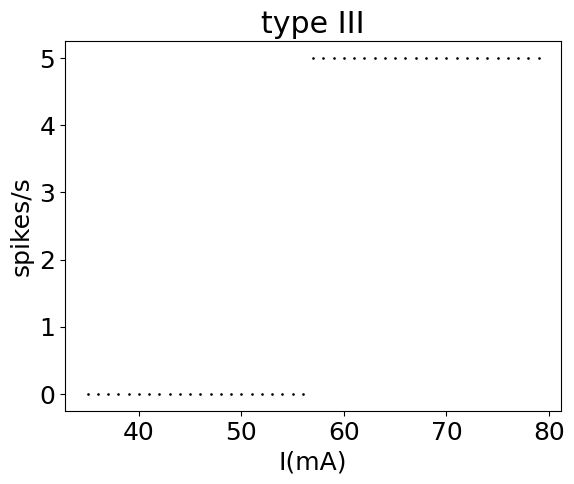

In [8]:
plt.rcParams.update({'font.size': 18})
plt.scatter(I_amps_type1,fr_type1,s=0.8,c='black')
plt.ylabel('spikes/s')
plt.xlabel('I(mA)')
plt.title('type I')
plt.show()

plt.scatter(I_amps_type2,fr_type2,s=0.8,c='black')
plt.ylabel('spikes/s')
plt.xlabel('I(mA)')
plt.title('type II')
plt.show()

plt.scatter(I_amps_type3,fr_type3,s=0.8,c='black')
plt.ylabel('spikes/s')
plt.xlabel('I(mA)')
plt.title('type III')
plt.show()

In [31]:
def run_ML_model(input_current,params,ex_type,plot_=True):
    '''
    Brian 2 simulation of Morris Lecar model for a given input current

    Args:
    input-current (TimedArray):  noisy input a neuron recieves in uA
    ex_type (str):  excitability type
    '''
    start_scope()
    defaultclock.dt = 1/20*ms
    g_Leak =params['g_Leak']
    g_slow =params['g_slow']
    E_Leak =params['E_Leak']
    E_fast =params['E_fast']
    V_slow =params['V_slow']
    beta_m =params['beta_m']
    gamma_m =params['gamma_m']  # Note that Figure caption says -15 which seems to be a typo
    g_fast =params['g_fast'] #
    phi_w =params['phi_w']
    beta_w =params['beta_w'] # change to change the neuron type
    gamma_w =params['gamma_w'] #
    C =params['C']


    # V,N-reduced system (Eq. 9 in article), note that the variables M and N (and lambda_N, etc.)
    # have been renamed to m and n to better match the Hodgkin-Huxley convention, and because N has
    # a reserved meaning in Brian (number of neurons)
    eqs = '''
    I = input_current(t,i) : amp
    dV/dt = (-g_Leak*(V - E_Leak) - g_fast*m_inf*(V - E_fast) - g_slow*n*(V - V_slow) + I)/C : volt
    dn/dt = (phi_w/tau_w)*(n_inf - n) : 1
    m_inf = 0.5*(1 + tanh((V - beta_m)/gamma_m)) : 1
    n_inf = 0.5*(1 + tanh((V - beta_w)/gamma_w)) : 1
    tau_w = 1/cosh((V - beta_w)/(2*gamma_w)) : 1

    '''

    G = NeuronGroup(1, eqs, method='exponential_euler')
    M = StateMonitor(G, ['V','I'], record=0)

    G.V = E_Leak
    print(input_current)
    G.namespace["input_current"] = input_current

    run(params['runtime'])
    spikes = scipy.signal.find_peaks(np.array(M.V[0]/mV),height=0.1)[0]

    if plot_:
        plot(M.t, M.V[0]/mV)

        xlabel('Time (ms)')
        ylabel('V(mV)');
        plt.title(f'type %s neuron with input mean %d uA variance %d uA '%(ex_type, np.mean(input_current.values)/uA,np.std(input_current.values)/uA))
        # plt.xlim(0,1000)
        plt.show()
    return spikes



# Gaussian Noise Simulation of different excitabilty types

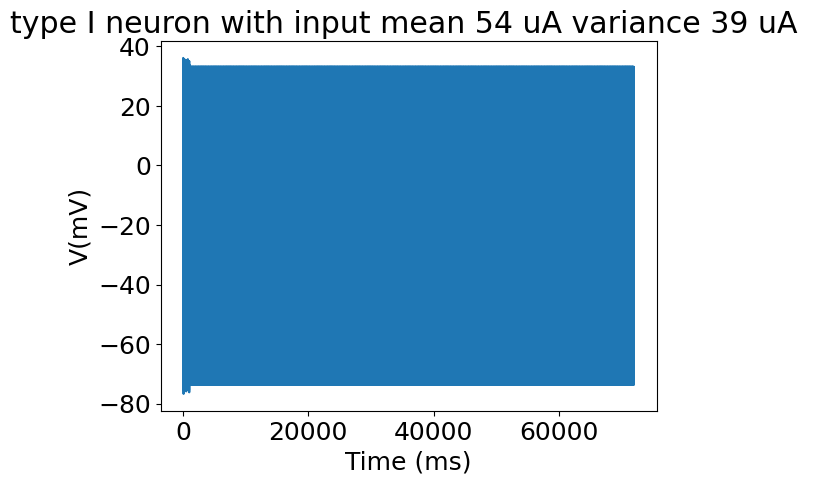

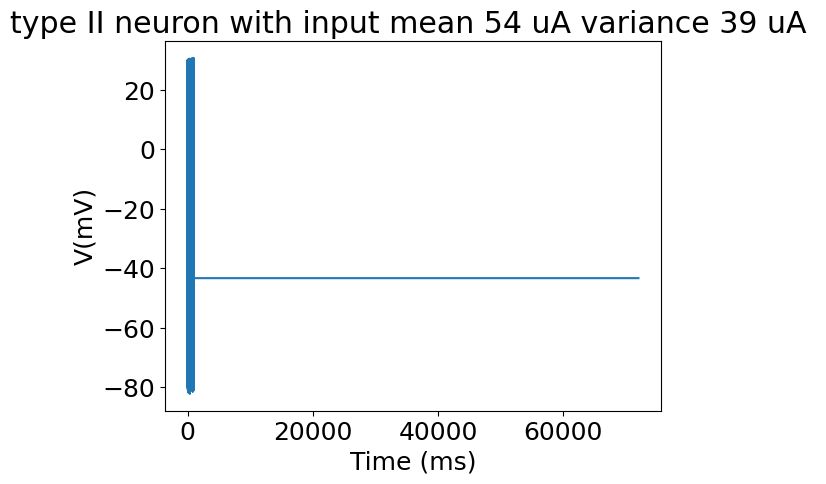

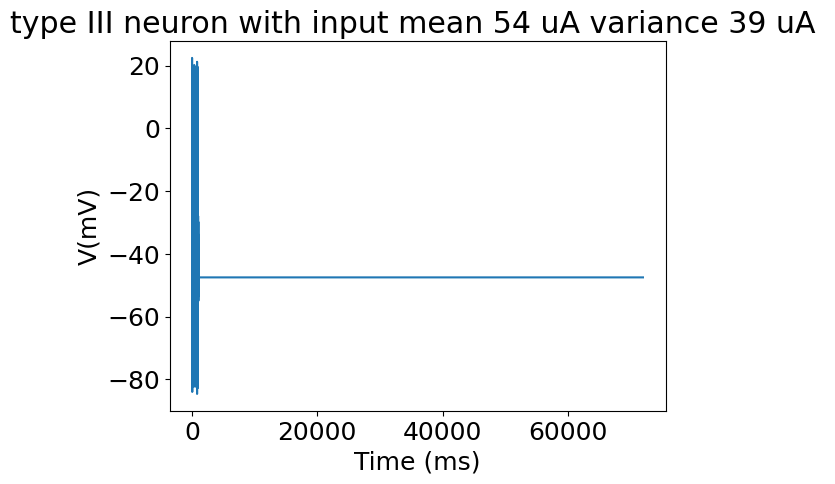

In [10]:
mu = 55
sig = 40000*1e-3
input_current = get_noisy_current(1000, 1./20*ms,mu,sig,uA)

run_ML_model(input_current, 'I',)
run_ML_model(input_current, 'II',)
run_ML_model(input_current, 'III',)


In [14]:

def OU_test(mu,dt,tau,sigma,unit,total_t):
    mu = mu
    dt = dt
    tau =tau
    sigma = sigma
    np.random.seed(0)
    time = np.arange(0,total_t,dt)
    x = np.zeros((len(time),1))
    x[0,0] =1

    for i in range(1,len(time)):
        # x[0,i] = x[0,i-1]+th*(mu-x[0,i-1])*dt+sig*sqrt(dt)*np.random.randn()
        x[i,0] = mu+((x[i-1,0]-mu)*np.exp(-dt/tau))+sigma*np.sqrt(1-np.exp(-2*dt/tau))*np.random.normal()
    # plt.plot(x[0])
    curr = TimedArray(x*unit, dt=dt*ms)
    return curr



#Input generated with Ornstein-Uhlenbeck (OU) process
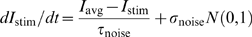

Text(0, 0.5, 'I(uA)')

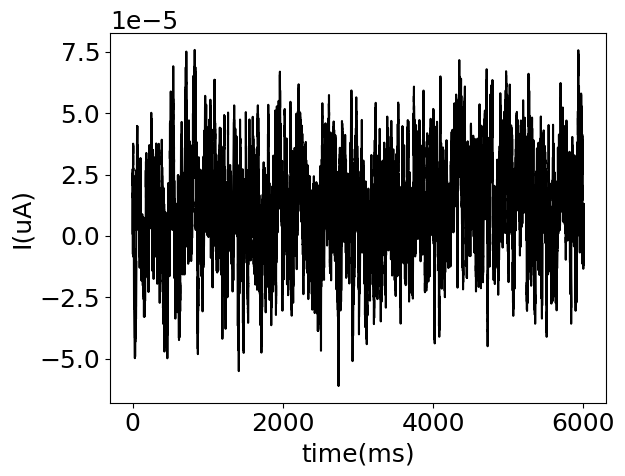

In [36]:
I = OU_test(10,1/20,10,20,uA,6000)
plot(np.arange(0,6000,1/20),I,c='black')
plt.xlabel('time(ms)')
plt.ylabel('I(uA)')


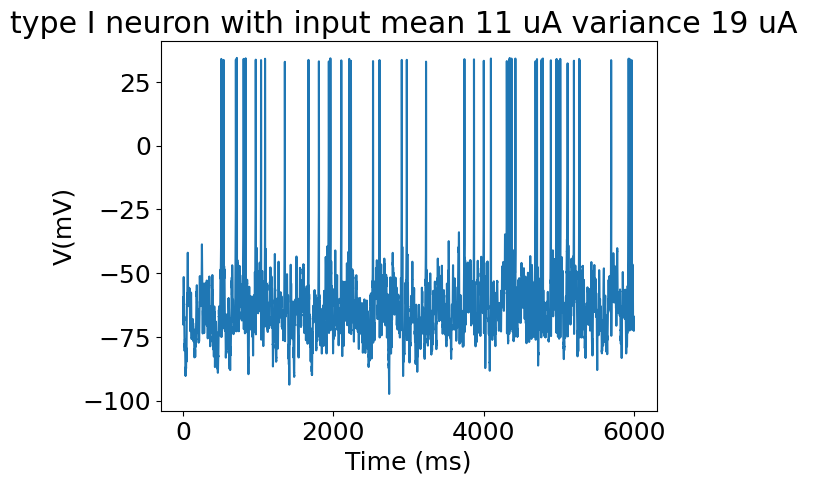

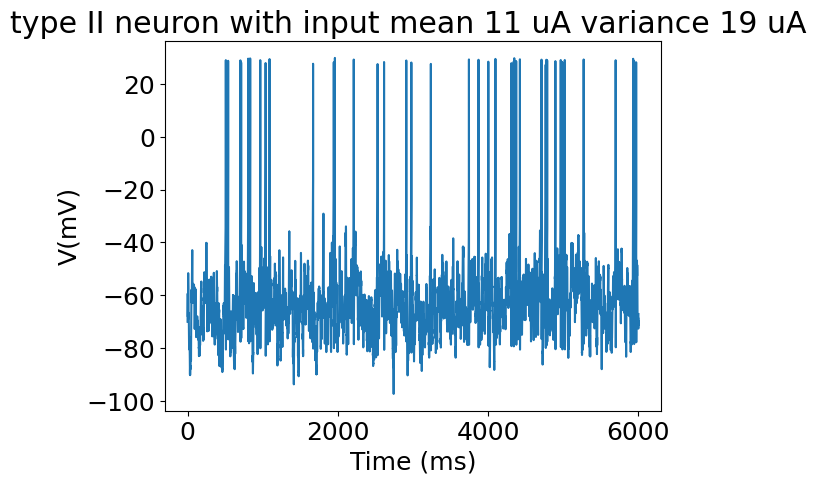

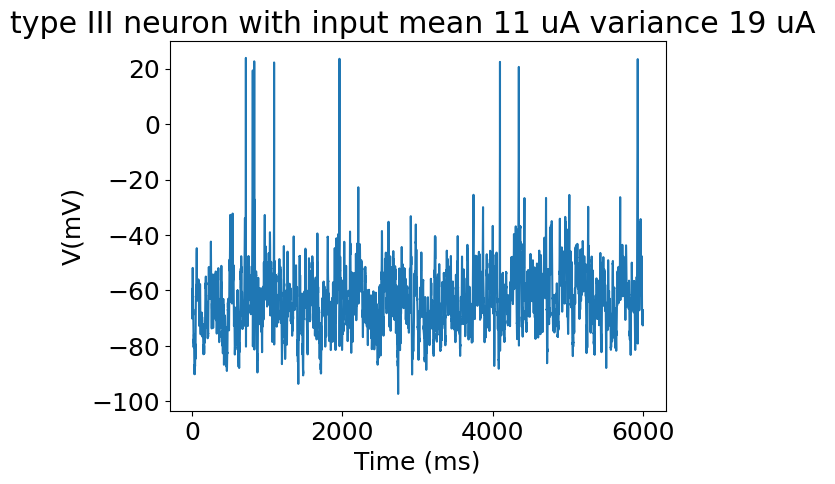

In [59]:
I_avg = 50 #uA
I_stim0 = 45 #uA
time = 1000
# input_current = get_noisy_current_OU(time, 1./20*ms, I_avg, I_stim0, uA)
input_current= OU_test(10,1/20,10,20,uA,6000)

params ={}

params['g_Leak'] = 2*mS
params['g_slow'] = 20*mS
params['E_Leak'] = -70*mV
params['E_fast'] = 50*mV
params['V_slow'] = -100*mV
params['beta_m'] = -1.2*mV
params['gamma_m'] = 18*mV  # Note that Figure caption says -15 which seems to be a typo
params['g_fast'] = 20*mS #
params['phi_w'] = 1.5/(10*ms) #
params['beta_w'] = -0*mV # change to change the neuron type
params['gamma_w'] = 10*mV #
params['runtime'] = 6000*ms
params['C'] = 2*uF
Spikes_type1 = run_ML_model(input_current,params,'I' )
params['beta_w'] = -13*mV
Spikes_type2 = run_ML_model(input_current,params,'II' )
params['beta_w'] = -20*mV
Spikes_type3 = run_ML_model(input_current,params,'III' )

Text(0, 0.5, 'I(uA)')

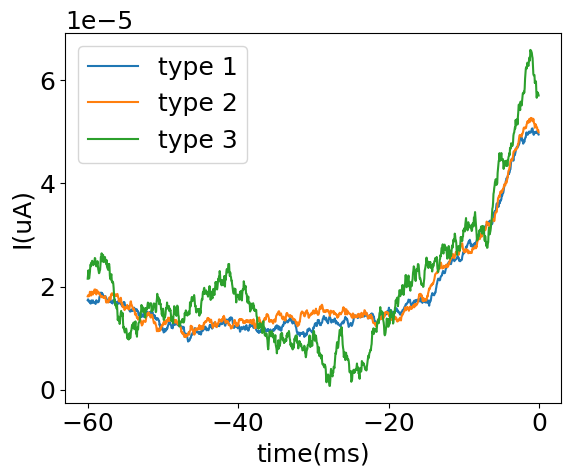

In [60]:
plt.plot(np.arange(-60,0,1/20),get_STA_temp(input_current.values,Spikes_type1))
plt.plot(np.arange(-60,0,1/20),get_STA_temp(input_current.values,Spikes_type2))
plt.plot(np.arange(-60,0,1/20),get_STA_temp(input_current.values,Spikes_type3))
plt.legend(['type 1','type 2','type 3'])
plt.xlabel('time(ms)')
plt.ylabel('I(uA)')

# Running model on the DataSet
 A whole-cell recording database of neuromodulatory action in the adult neocortex Xuan Yan, Niccolo Calcini, Payam Safavi, Asli Ak, Koen Kole, Fleur Zeldenrust, Tansu Celikel
bioRxiv 2022.01.12.476007; doi: https://doi.org/10.1101/2022.01.12.476007)

In [37]:
import scipy.io as spio

In [41]:
#@title functions
def loadmat_(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
#     try:
    if ('analyzed' in filename )and ('_CC_' not in filename):
        Data = []
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        try:
            for i in range(len(data)):
                data_ = data[i]
                data_ = _todict(data_)
                Data.append(_check_keys(data_))
            return Data
        except:
            data_ = data
            data_ = _todict(data_)
            Data.append(_check_keys(data_))
            return Data
    elif ('analyzed' in filename) and ('_CC_' in filename):
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        data = _todict(data)
    else:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        data = _todict(data)
    return _check_keys(data)

#     except:
#         print('here')
#         pass
def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict

def _todict(matobj):
    '''
    A recursive function which constructs nested dictionaries from matobjects
    '''
    dict = {}
    try:
      for strg in matobj._fieldnames:
          elem = matobj.__dict__[strg]
          if isinstance(elem, spio.matlab.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    except:
        for strg in matobj.keys():
          elem = matobj[strg]
          if isinstance(elem, spio.matlab.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    return dict

In [50]:
path = "D:/CurrentClamp/FN_analyzed/170615_NC_19_FN_analyzed.mat"
def return_data_I(path):
    '''
    Loads the data from a single data file and returns input current

    args-
    path: path to the file
    '''
    dat = loadmat_(path)
    I = dat[0]['input_current']/5
    np.expand_dims(I[:20*1000],1)
    V = dat[0]['membrane_potential']
    unit_time = 1/20. * ms
    unit = uA
    tmp = np.expand_dims(I[:20*36000],1)*unit
    curr = TimedArray(tmp, dt=1. * unit_time)
    input_current = curr
    return input_current


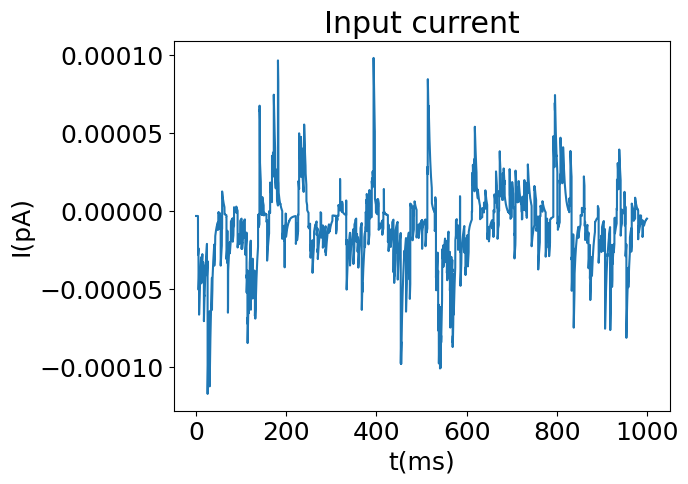

In [46]:
plt.plot(np.arange(0,1000,0.05),return_data_I(path))
plt.xlabel('t(ms)')
plt.ylabel('I(pA)')
plt.title('Input current')
plt.show()

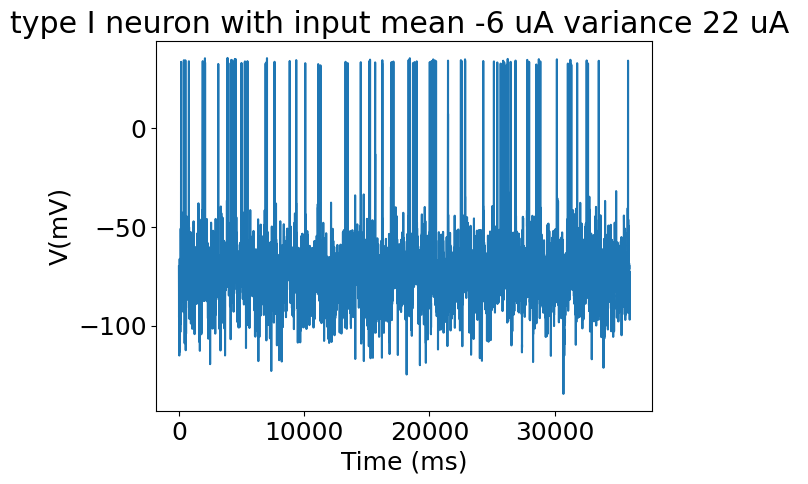

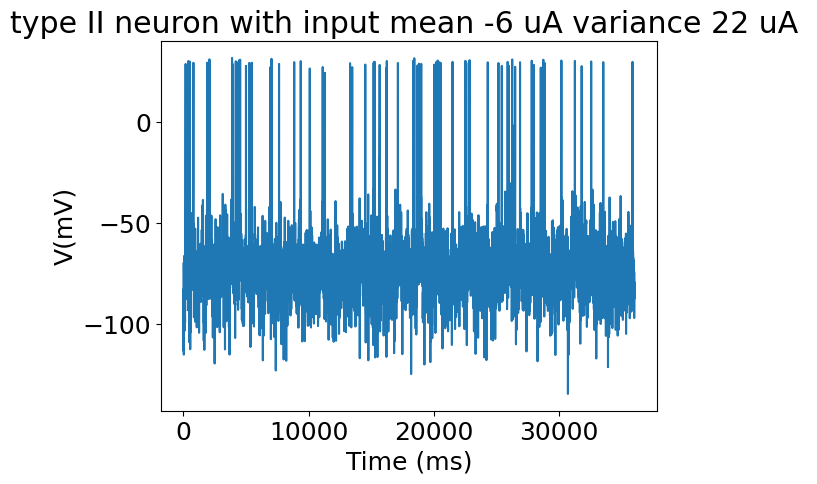

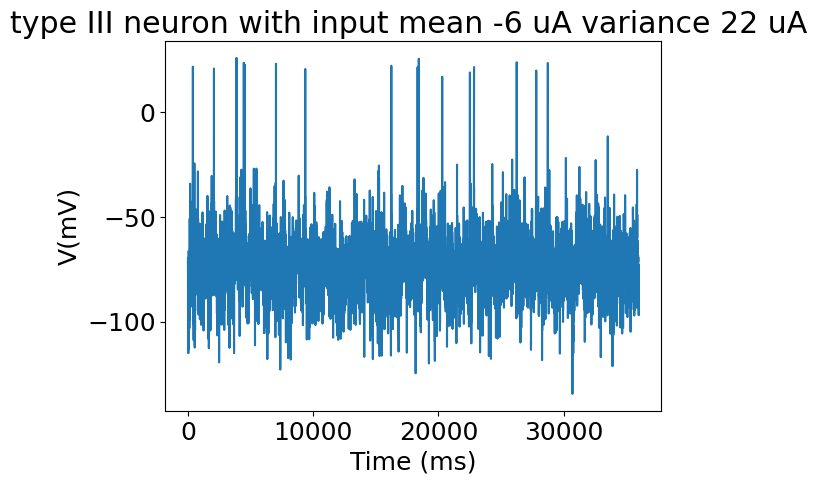

In [51]:
input_current = return_data_I(path)
params['beta_w'] = -0*mV
params['runtime'] = 36000*ms
spks1 = run_ML_model(input_current,params, 'I',)
plt.show()
params['beta_w'] = -13*mV
spks2 = run_ML_model(input_current,params, 'II',)
plt.show()
params['beta_w'] = -24*mV
spks3 = run_ML_model(input_current,params, 'III',)
plt.show()


Text(0, 0.5, 'I(uA)')

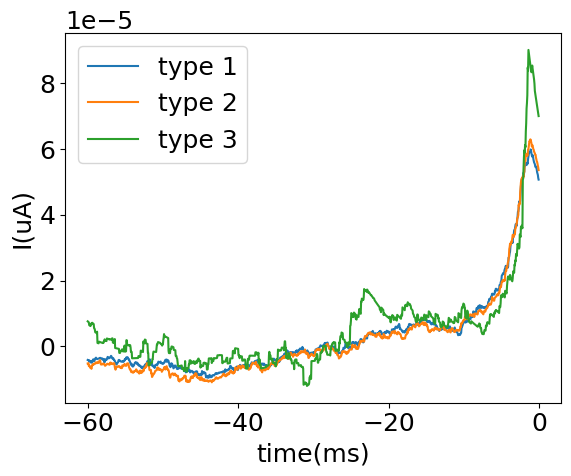

In [58]:
def get_STA_temp(I,spikes):

    
    spk_ind = spikes
    sta = []
    TIME = 60*20
    for i in spk_ind:
        # if len(I[i-TIME:i,0]) :
        sta.append(I[i-TIME:i,0])

    return np.mean(np.array(sta).T,axis=1)

plt.plot(np.arange(-60,0,1/20),get_STA_temp(input_current.values,spks1))
plt.plot(np.arange(-60,0,1/20),get_STA_temp(input_current.values,spks2))
plt.plot(np.arange(-60,0,1/20),get_STA_temp(input_current.values,spks3))
plt.legend(['type 1','type 2','type 3'])
plt.xlabel('time(ms)')
plt.ylabel('I(uA)')

#Power Spectral Density of the Input

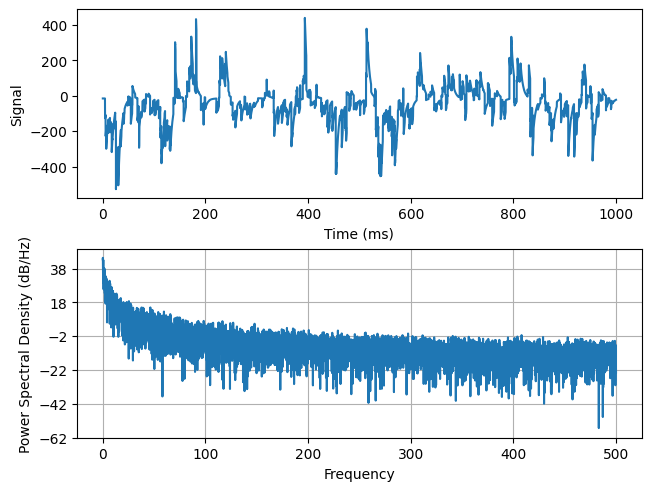

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.mlab as mlab

# Fixing random state for reproducibility

dt = 1/20
t = np.arange(0, 1000, dt)
dat = loadmat_(path)
I = dat[0]['input_current'][:1000*20]

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(t, I)
ax0.set_xlabel('Time (ms)')
ax0.set_ylabel('Signal')
ax1.psd(I,20000,1000)

plt.show()

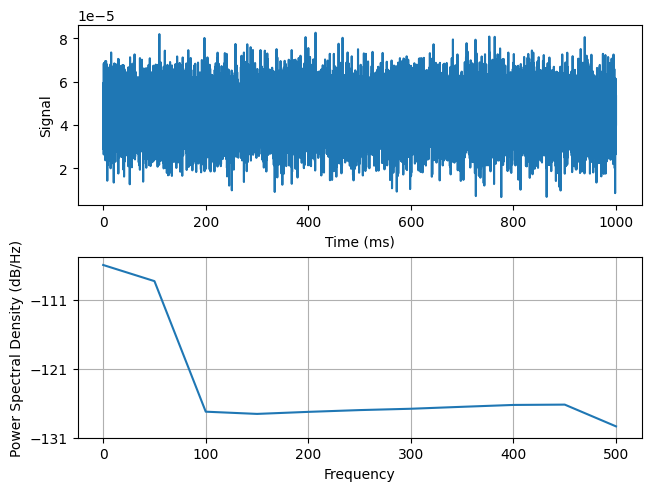

In [ ]:
input_current = get_noisy_current_OU(1000, 1./20*ms,50,45,  uA)


import matplotlib.pyplot as plt
import numpy as np

import matplotlib.mlab as mlab

# Fixing random state for reproducibility

dt = 1/20
t = np.arange(0, 1000, dt)
# dat = loadmat_(path)
I = input_current

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(t, I)
ax0.set_xlabel('Time (ms)')
ax0.set_ylabel('Signal')
ax1.psd(I.values[:,0],20,1000)

plt.show()